In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [3]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

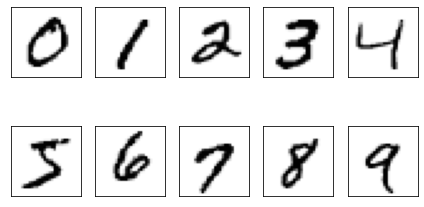

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

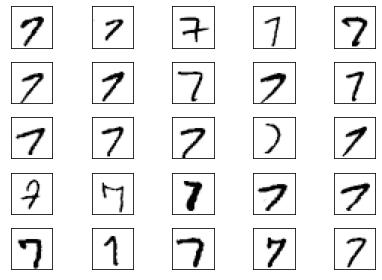

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [6]:
import numpy as np

In [7]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [8]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

def softmax_grad(softmax):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)


class NeuralNetMLP2:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)


        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)


        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)


        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1,a_h2, a_out

    def backward(self, x, a_h1,a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out =  a_out * (1. - a_out)  # softmax derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)

        # [n_examples, n_hidden]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative
        delta_out2 = d_loss__a_h2 * d_a_h__d_z_h2

        # [n_examples, n_features]
        d_z_h__d_w_h = a_h1
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h__d_z_h2).T, d_z_h__d_w_h)
        d_loss__d_b_h2= np.sum((d_loss__a_h2 * d_a_h__d_z_h2), axis=0)
        



        
        #################################        
        # Part 3: dLoss/dHiddenWeightsss
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out2, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h2,d_loss__d_b_h2,
                d_loss__d_w_h, d_loss__d_b_h)

In [9]:
model = NeuralNetMLP2(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [10]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [11]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.9%


In [33]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [34]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

ValueError: too many values to unpack (expected 2)

In [14]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1,a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2 ,d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1,a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

def train_1hidden(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [15]:
np.random.seed(123) # for the training set shuffling
from sklearn.metrics import roc_auc_score

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

def compute_AUC(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    lst_proba=[]
    lst_targets=[]
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        
        lst_proba.append(probas)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        lst_targets.append(onehot_targets)
    lst_proba=np.concatenate(lst_proba, axis=0)
    lst_targets=np.concatenate(lst_targets, axis=0)
    Auc= roc_auc_score(lst_targets, lst_proba)
    return Auc
    
compute_AUC(model, X_valid, y_valid)


Epoch: 001/050 | Train MSE: 0.04 | Train Acc: 83.26% | Valid Acc: 82.86%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 87.72% | Valid Acc: 87.12%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.04% | Valid Acc: 88.76%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.94% | Valid Acc: 89.54%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.61% | Valid Acc: 90.30%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.96% | Valid Acc: 90.58%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.53% | Valid Acc: 91.22%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.79% | Valid Acc: 91.40%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.23% | Valid Acc: 91.86%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.44% | Valid Acc: 92.22%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.71% | Valid Acc: 92.30%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.91% | Valid Acc: 92.62%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 93.25% | Valid Acc: 92.98%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.42

In [38]:
epoch_loss_2_layers= epoch_loss
epoch_train_acc_2_layers= epoch_train_acc
epoch_valid_acc_2_layers= epoch_valid_acc

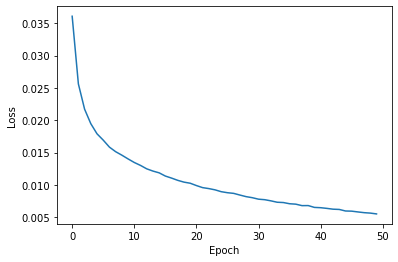

In [30]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

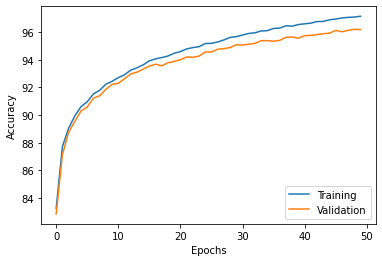

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [45]:
model_1hidden= NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)
epoch_loss_1hidden, epoch_train_acc_1hidden, epoch_valid_acc_1hidden = train_1hidden(
    model_1hidden, X_train, y_train, X_valid, y_valid,num_epochs=50, learning_rate=0.1)

KeyboardInterrupt: 

In [47]:
# test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
# print(f'Test accuracy: {test_acc*100:.2f}%')

ValueError: too many values to unpack (expected 2)

In [49]:
res= epoch_loss_1hidden, epoch_train_acc_1hidden, epoch_valid_acc_1hidden, epoch_loss_2_layers,epoch_train_acc_2_layers,epoch_valid_acc_2_layers
# save the results to a pickle file
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(res, f)


In [59]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def weights_init(m):
    m.weight.data.normal_(0.0, 0.1)
    m.bias.data.fill_(0)


class Net(nn.Module):
    def __init__(self,num_features,num_hidden,num_classes):
        super().__init__()
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.out = nn.Linear(num_hidden, num_classes)
        weights_init(self.fc1)
        weights_init(self.fc2)
        weights_init(self.out)
        

    def forward(self, x):

        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.softmax(self.out(x))
        return x


net = Net(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)



In [60]:
train_set= list(zip(X_train,y_train))
valid_set= list(zip(X_valid,y_valid))
test_set=  list(zip(X_test,y_test))
trainloader=torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
validloader=torch.utils.data.DataLoader(valid_set,batch_size=100,shuffle=True)
testloader=torch.utils.data.DataLoader(test_set,batch_size=100,shuffle=True)
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
EPOCH=50

In [61]:
# import tqdm as tqdm
loss_array=[]
acc_array=[]
for epoch in range(EPOCH):  # loop over the dataset multiple times

    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        net.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels=F.one_hot(labels,10)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        current=0

    net.eval()     # Optional when not using Model Specific layer
    correct = 0.0
    for i, (inputs,labels) in enumerate (validloader):
        output = net(inputs.float())
        optimizer.step()
        # print(output)
        # print(labels)
        # print(sdfasdfas)
        output=torch.argmax(output.data, 1)
        correct += (output == labels).float().sum()

    accuracy = 100 * correct / len(valid_set)
    acc_array.append(accuracy)
    
    # trainset, not train_loader
    # probably x in your case

    print("Accuracy = {}".format(accuracy))

    


    print(epoch+1, epoch_loss / len(train_set))
    loss_array.append(epoch_loss / len(train_set))

print('Finished Training')

/home/izmaylov/.conda/envs/Bert2/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy = 27.65999984741211
1 0.08867268022149802
Accuracy = 42.79999923706055
2 0.07812598068267107
Accuracy = 61.7599983215332
3 0.06805904787033797
Accuracy = 66.55999755859375
4 0.05760369373654777
Accuracy = 62.70000076293945
5 0.048877353060313246
Accuracy = 69.22000122070312
6 0.042111791467124765
Accuracy = 75.9000015258789
7 0.0363935299471698
Accuracy = 80.72000122070312
8 0.03224051705646244
Accuracy = 73.33999633789062
9 0.029063087426633997
Accuracy = 81.08000183105469
10 0.027005606060000985
Accuracy = 83.05999755859375
11 0.025097244169393722
Accuracy = 80.31999969482422
12 0.023464211990887468
Accuracy = 77.55999755859375
13 0.02244954775510864
Accuracy = 85.23999786376953
14 0.021637445214119824
Accuracy = 81.30000305175781
15 0.020526413416320628
Accuracy = 82.04000091552734
16 0.020089324781755832
Accuracy = 82.95999908447266
17 0.019596532454968178
Accuracy = 85.27999877929688
18 0.019160663859326053
Accuracy = 85.16000366210938
19 0.01838783377527513
Accuracy = 86

In [78]:
acc_array

[tensor(27.6600),
 tensor(42.8000),
 tensor(61.7600),
 tensor(66.5600),
 tensor(62.7000),
 tensor(69.2200),
 tensor(75.9000),
 tensor(80.7200),
 tensor(73.3400),
 tensor(81.0800),
 tensor(83.0600),
 tensor(80.3200),
 tensor(77.5600),
 tensor(85.2400),
 tensor(81.3000),
 tensor(82.0400),
 tensor(82.9600),
 tensor(85.2800),
 tensor(85.1600),
 tensor(86.1600),
 tensor(86.4000),
 tensor(85.3600),
 tensor(88.0600),
 tensor(86.8600),
 tensor(88.2400),
 tensor(88.3600),
 tensor(89.0600),
 tensor(87.3800),
 tensor(89.),
 tensor(86.7200),
 tensor(89.4800),
 tensor(87.9600),
 tensor(87.6800),
 tensor(87.2800),
 tensor(88.2200),
 tensor(90.1600),
 tensor(89.5800),
 tensor(89.3200),
 tensor(89.3000),
 tensor(89.2600),
 tensor(89.4000),
 tensor(88.8600),
 tensor(90.5000),
 tensor(90.7200),
 tensor(90.6800),
 tensor(90.9200),
 tensor(89.6600),
 tensor(90.6200),
 tensor(88.5800),
 tensor(91.1600)]

In [63]:
# calculate macro auc 
import sklearn.metrics as metrics

y_pred=[]
y_true=[]
for i,data in enumerate(testloader,0):
    inputs,labels=data
    labels=F.one_hot(labels,10)
    outputs=net(inputs.float())
    y_pred.append(outputs.detach().numpy())
    y_true.append(labels.detach().numpy())
y_pred=np.concatenate(y_pred)
y_true=np.concatenate(y_true)
print(f'Macro AUC: {metrics.roc_auc_score(y_true,y_pred,average="macro",multi_class="ovr")}')
# print accuracy
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_true,axis=1)
print(f'Accuracy: {metrics.accuracy_score(y_true,y_pred)}')


/home/izmaylov/.conda/envs/Bert2/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/izmaylov/.conda/envs/Bert2/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Macro AUC: 0.9919413041161063
Accuracy: 0.9064761904761904


In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
# plt.plot(range(len(epoch_loss_1hidden)), epoch_loss_1hidden)
plt.plot(range(len(loss_torch)), loss_torch)

plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

In [64]:
# pickle load the results
import pickle
with open('results.pkl', 'rb') as f:
    res = pickle.load(f)
    epoch_loss_1hidden, epoch_train_acc_1hidden, epoch_valid_acc_1hidden, epoch_loss_2_layers,epoch_train_acc_2_layers,epoch_valid_acc_2_layers = res


In [65]:
loss_array

[0.08867268022149802,
 0.07812598068267107,
 0.06805904787033797,
 0.05760369373654777,
 0.048877353060313246,
 0.042111791467124765,
 0.0363935299471698,
 0.03224051705646244,
 0.029063087426633997,
 0.027005606060000985,
 0.025097244169393722,
 0.023464211990887468,
 0.02244954775510864,
 0.021637445214119824,
 0.020526413416320628,
 0.020089324781755832,
 0.019596532454968178,
 0.019160663859326053,
 0.01838783377527513,
 0.01790036978200078,
 0.017452652638100766,
 0.017149271070957185,
 0.01708251478108154,
 0.016530508833768016,
 0.016281572364228353,
 0.015999690517359836,
 0.0158052612836896,
 0.015545354765543544,
 0.0154437167072584,
 0.015144622740759091,
 0.01509537150427191,
 0.014751512701199813,
 0.014752772016535428,
 0.01456264466449449,
 0.014539245970081539,
 0.014364413009025157,
 0.014008042801552536,
 0.013925985136831348,
 0.013868043833115901,
 0.013697810160969808,
 0.013673974122767421,
 0.013461932412941347,
 0.013394939915319396,
 0.013213713238523765,
 0.01

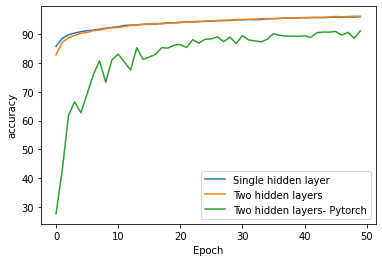

In [77]:
plt.plot(range(50), epoch_valid_acc_1hidden, label='Single hidden layer')
plt.plot(range(50), epoch_valid_acc_2_layers, label='Two hidden layers')
plt.plot(range(50), acc_array, label='Two hidden layers- Pytorch')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()


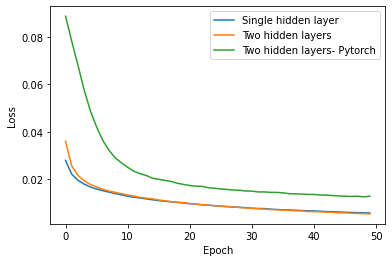

In [79]:
plt.plot(range(50), epoch_loss_1hidden, label='Single hidden layer')
plt.plot(range(50), epoch_loss_2_layers, label='Two hidden layers')
plt.plot(range(50), loss_array, label='Two hidden layers- Pytorch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()